In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Tulsi Mundada
- PRN : 240340128035
- Date: 31/05/2024

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [14]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm # type: ignore
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();



In [16]:
###-----------------
### Global Variables
###-----------------
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
logDir = './logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [17]:
###-----------------
### Hyper Parameters
###-----------------
EPOCHS = 50 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32
REG_LAMBDA = 0.001
TEST_SIZE = 0.2

# Early Stoping
PATIENCE = 20
LR_PATIENCE = 10
LR_Factor = 0.1 

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [18]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename)
test_df = pd.read_csv(test_filename)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [19]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [20]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

In [21]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [22]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [23]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28,28,1])

    label = row[0]

    return feature, label

## For Train DataSet

In [24]:
#Converting dataset into tesnorfolow
tmp_df = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_df.map(split_feature_label)

# # data for validation
# X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# #X_test = X_test/255.0

train_ds = train_ds.batch(BATCH_SIZE)

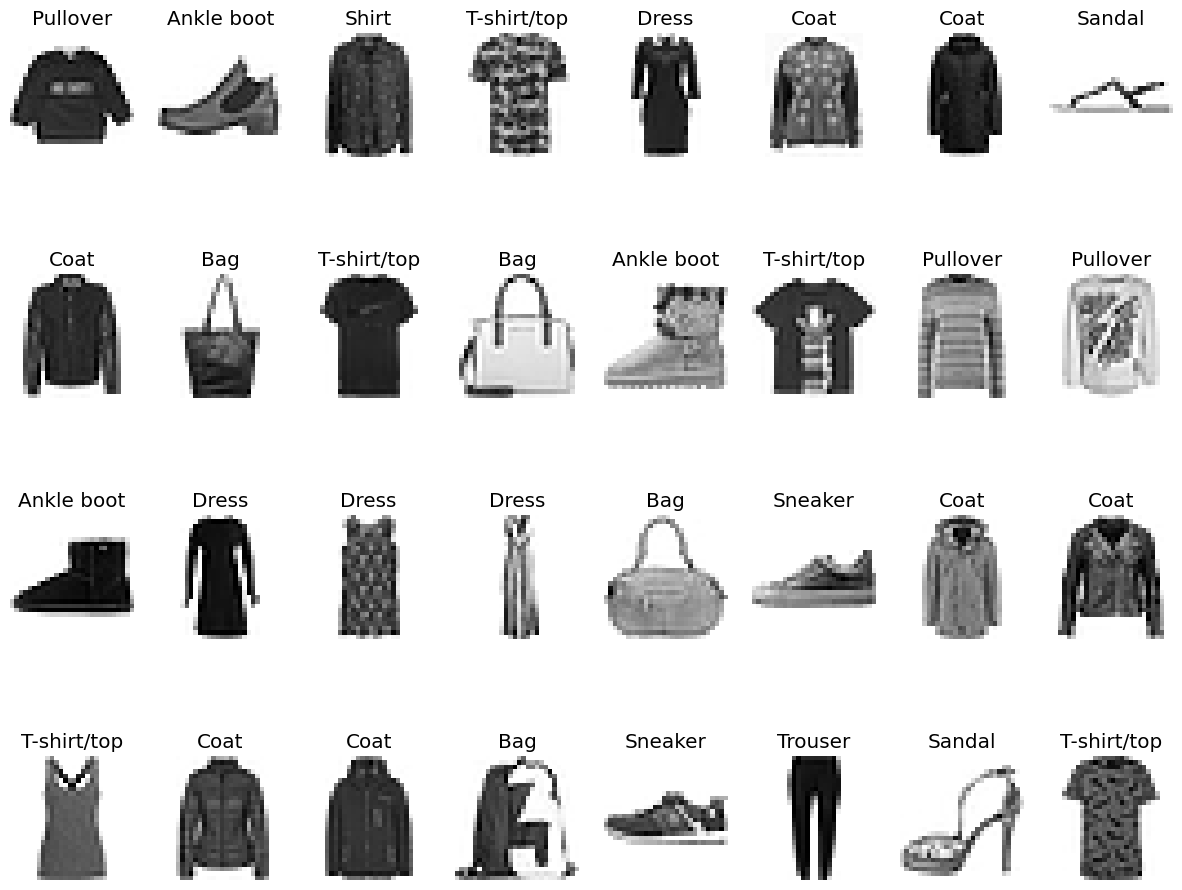

In [25]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

## For Test DataSet

In [26]:
# Coverting dataset inyo tenserflow
tmp_df = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_df.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

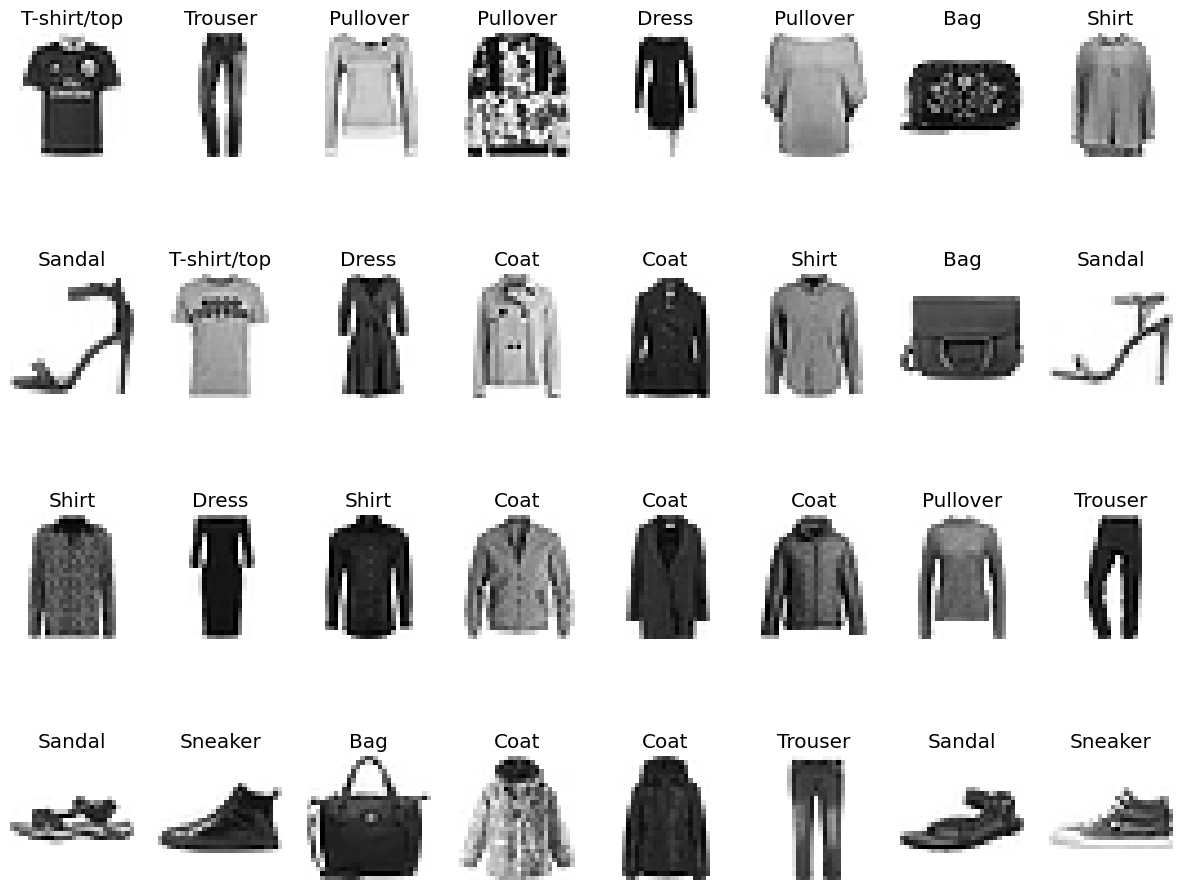

In [27]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

In [28]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(32, 28, 28, 1) (32,)


In [29]:
for features, labels in train_ds.take(1):
    print (features, labels)

tf.Tensor(
[[[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
 

In [30]:
for features, labels in test_ds.take(1):
    print (features.shape, labels.shape)

(32, 28, 28, 1) (32,)


In [31]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Prepare Model

build tf.keras.Sequential model by stcking. chos an optoimizer and loss function

In [32]:
# Model creating

k_init = tf.keras.initializers.GlorotUniform(seed =  RANDOM_STATE)
k_reg = tf.keras.regularizers.L2(l2 =  REG_LAMBDA)

dor1 = 0.4
dor = 0.3
dor3 = 0.2
dor4 = 0.12

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28],name="inputLayer"),

    # Set Layer1
    tf.keras.layers.Dense(300,
                           kernel_initializer =  k_init,
                           kernel_regularizer = k_reg,
                           name="hiddenLayer1"),

     # BN1
    tf.keras.layers.BatchNormalization(),
    
    #tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(dor1),

    # Set Layer2
    tf.keras.layers.Dense(100, 
                          kernel_initializer =  k_init,
                          kernel_regularizer = k_reg,
                          name="hiddenLayer2"),
    # BN2
    tf.keras.layers.BatchNormalization(),
    
    #tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(dor1),


    # Output Layer
    tf.keras.layers.Dense(10, activation="softmax", name="outputLayer")
])

In [33]:
checkpoint_path = os.path.join(modelDir, subDir, 'MNIST_DATASET') # save the model

early_stoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE, # it will contiue for given patience value after that stop
    verbose=2,
    mode='auto',
    restore_best_weights=True, # It restore the best weight before 20 epochs
)

log_dir = os.path.join(logDir,'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
loss_fn =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

optimizer =  tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(optimizer =  optimizer,loss  =  loss_fn,metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 outputLayer (Dense)         (None, 10)                1

In [36]:
history =  model.fit(train_ds,
                     validation_data=test_ds,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS,
                     callbacks = [early_stoping_callback],
                     verbose=2)

Epoch 1/50


c:\Users\dai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




1875/1875 - 13s - loss: 0.8266 - accuracy: 0.8033 - val_loss: 0.7283 - val_accuracy: 0.8022 - 13s/epoch - 7ms/step
Epoch 2/50
1875/1875 - 10s - loss: 0.6210 - accuracy: 0.8156 - val_loss: 0.6753 - val_accuracy: 0.8069 - 10s/epoch - 5ms/step
Epoch 3/50
1875/1875 - 9s - loss: 0.5925 - accuracy: 0.8190 - val_loss: 0.6400 - val_accuracy: 0.8136 - 9s/epoch - 5ms/step
Epoch 4/50
1875/1875 - 9s - loss: 0.5722 - accuracy: 0.8233 - val_loss: 0.6212 - val_accuracy: 0.8156 - 9s/epoch - 5ms/step
Epoch 5/50
1875/1875 - 9s - loss: 0.5520 - accuracy: 0.8278 - val_loss: 0.5960 - val_accuracy: 0.8223 - 9s/epoch - 5ms/step
Epoch 6/50
1875/1875 - 9s - loss: 0.5355 - accuracy: 0.8312 - val_loss: 0.5799 - val_accuracy: 0.8257 - 9s/epoch - 5ms/step
Epoch 7/50
1875/1875 - 9s - loss: 0.5237 - accuracy: 0.8343 - val_loss: 0.5739 - val_accuracy: 0.8270 - 9s/epoch - 5ms/step
Epoch 8/50
1875/1875 - 9s - loss: 0.5156 - accuracy: 0.8359 - val_loss: 0.5708 - val_accuracy: 0.8275 - 9s/epoch - 5ms/step
Epoch 9/50
18

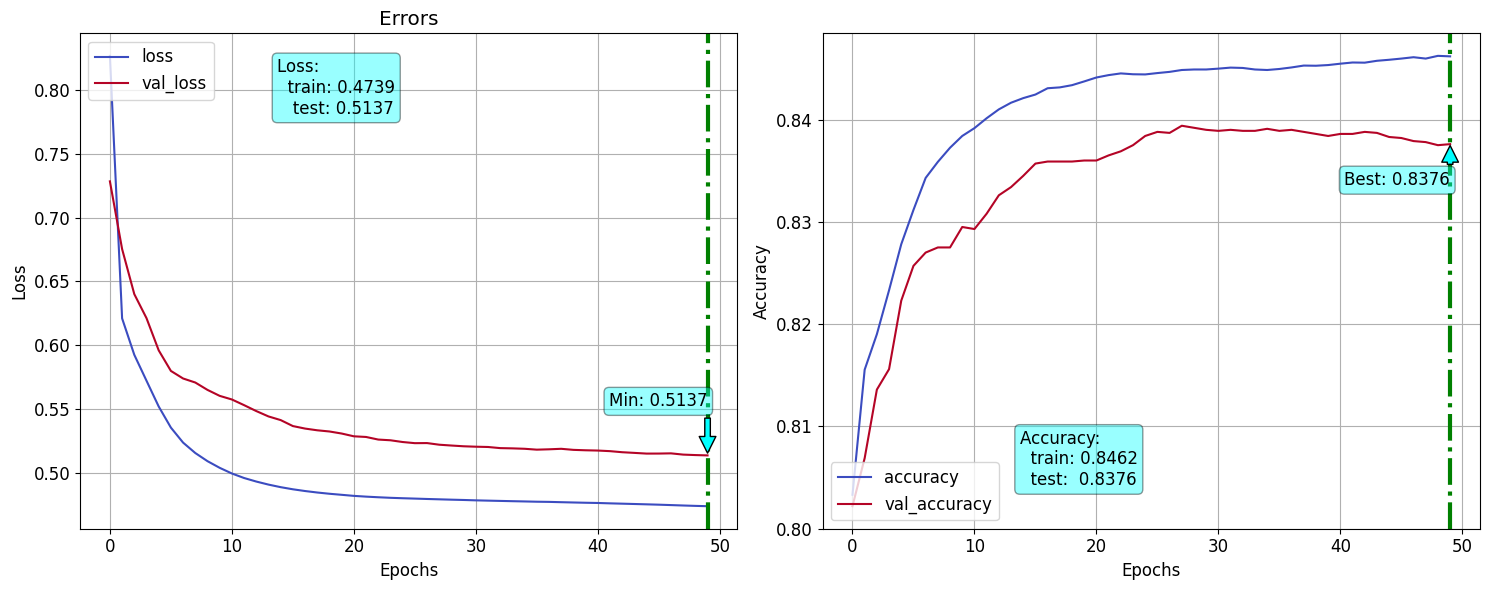

In [37]:
hi = pd.DataFrame(history.history)
fn_plot_tf_hist(hi)

For  L1 Reularization
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 outputLayer (Dense)         (None, 10)                1010      
                                                                 
=================================================================

Loss value is high And acuuracy is also not good. 

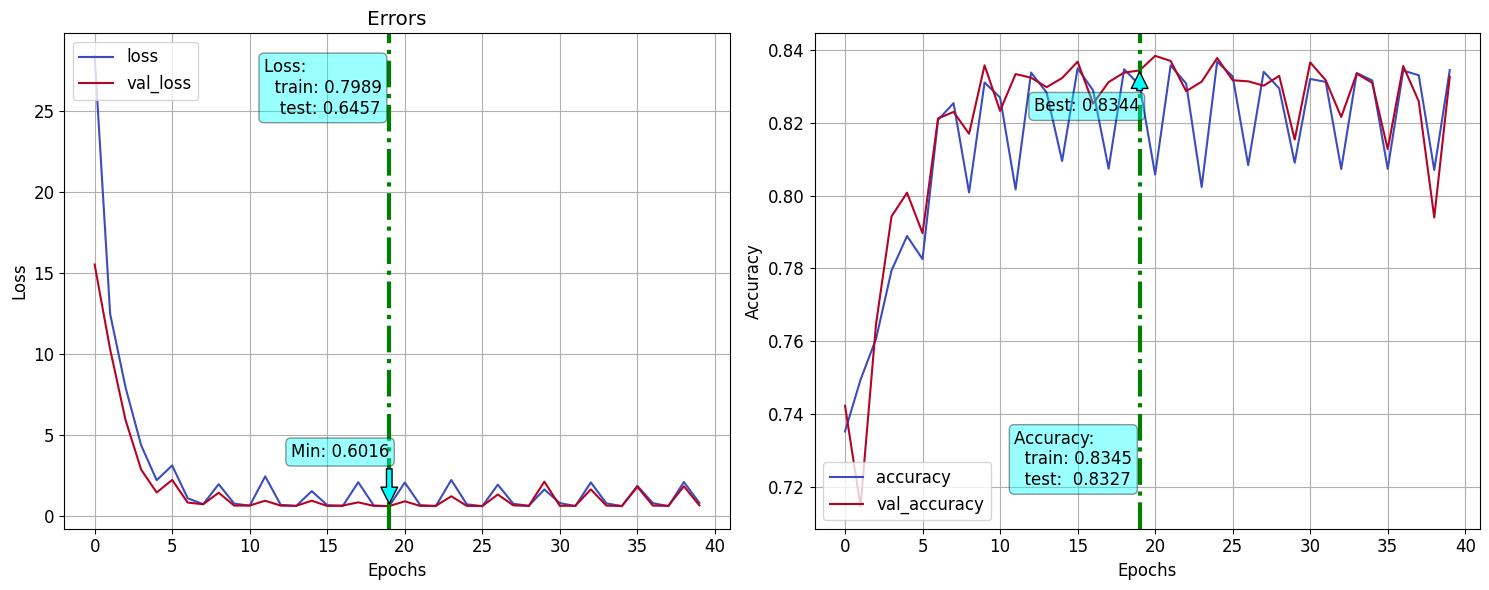



For  L1  with DropOut

Model: "sequential"


Layer (type)                Output Shape              Param #   
=================================================================
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 outputLayer (Dense)         (None, 10)    

 This is not Idel model by obsrving the graph.


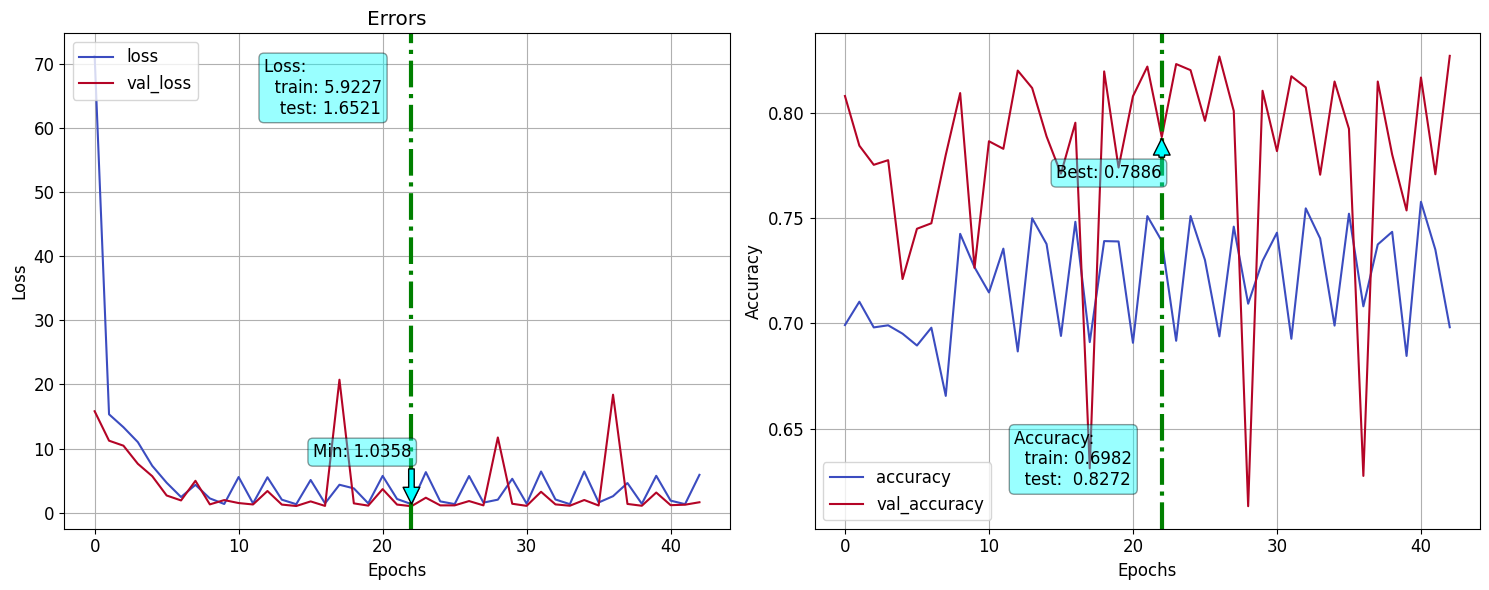



For  L1  with BachNormalization

Model: "sequential"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 outputLayer (Dense)         (None, 10)                1010      
                                                                 
=================================================================

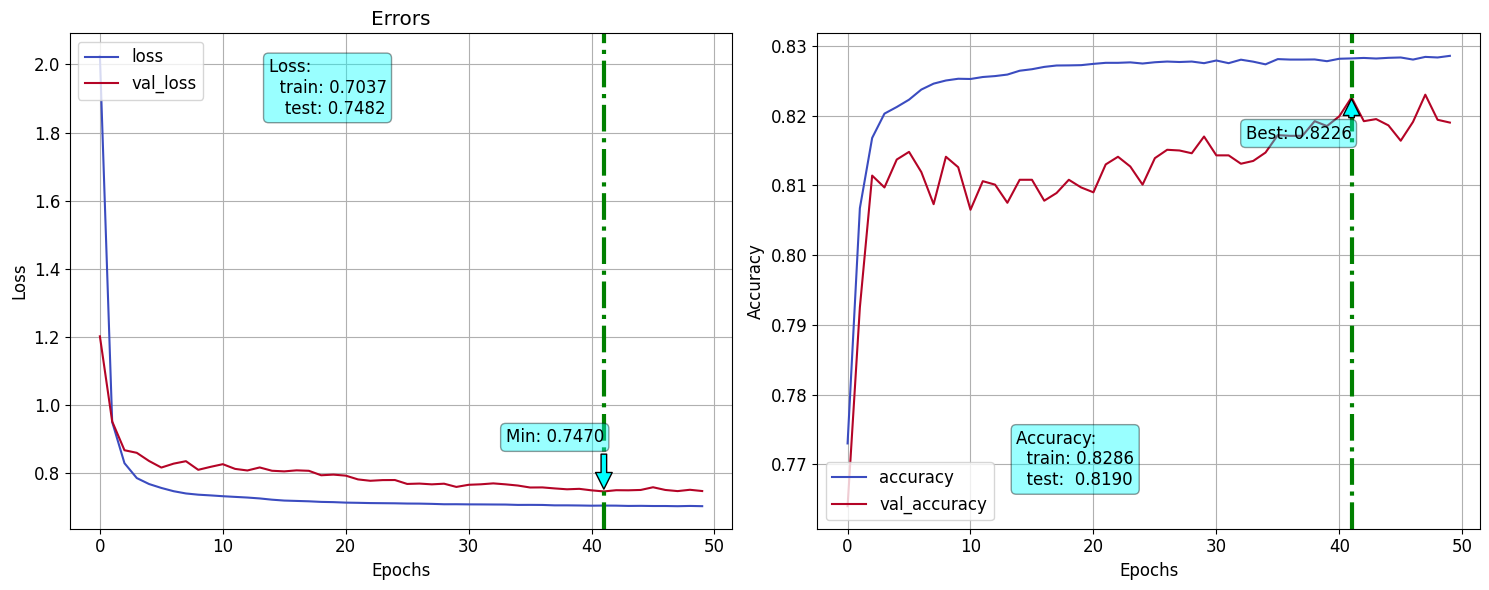




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 batch_normalization_2 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 outputLayer (Dense)         (None, 10)                1010      
                                                                 
=================================================================
Total params: 268210 (1.02 MB)
Trainable params: 267410 (1.02 MB)
Non-trainable params: 800 (3.12 KB



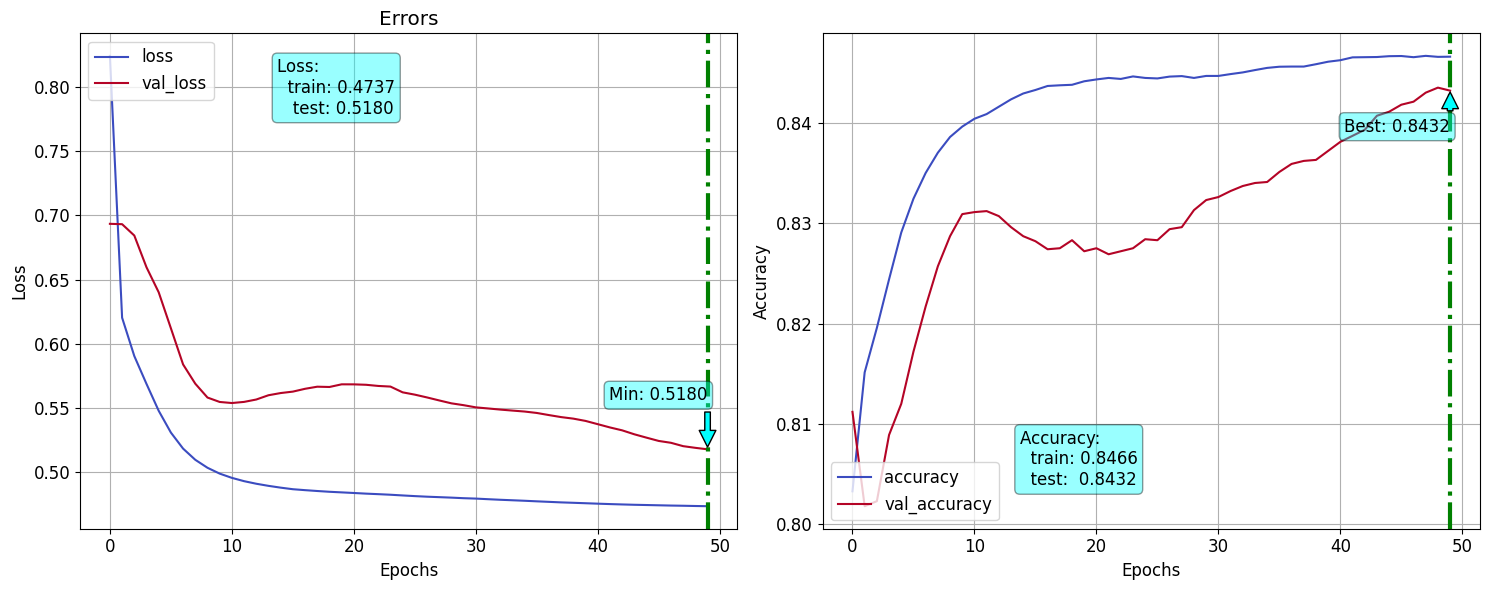



In [38]:
#Saving the model
model.save("model.h5")

c:\Users\dai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
